In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


In [2]:
%config Completer.use_jedi = False

# 1.Loading the dataset

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# 2.Exploratory data analysis

# 2.1 Check missing values

## Check missing values

In [5]:
def plot_missing_data(dataset,tittle):
    fig,ax = plt.subplots(figsize=(5,5))
    sns.heatmap(dataset.isnull(),cbar = False)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


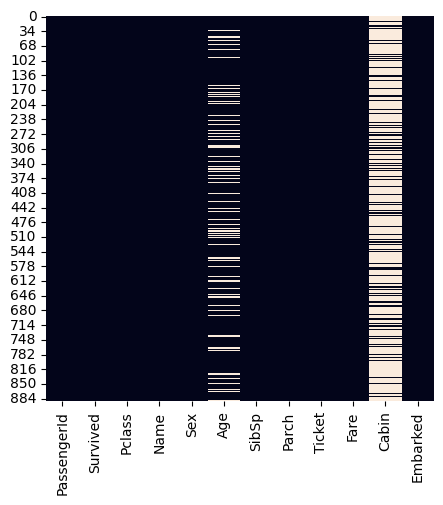

In [7]:
plot_missing_data(train_data, "Training Dataset")

In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


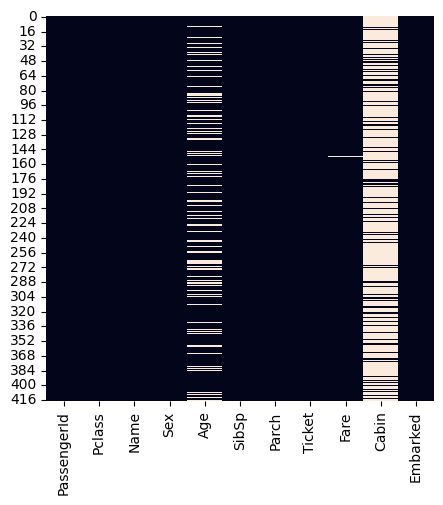

In [9]:
plot_missing_data(test_data, "Test Dataset")

### Obeservtions:

From the blots above we can see that both training as well as test dataset contain features with missing values. However, the most sparse features are Age as well as Cabin.

As we do not know the how much information the features yield, further investigation is needed.

In [10]:
def bar_chart_stacked(dataset, feature, stacked = True):
    survived = dataset[dataset['Survived']==1][feature].value_counts()
    dead = dataset[dataset['Survived']==0][feature].value_counts()
    df_survived_dead = pd.DataFrame([survived,dead])
    df_survived_dead.index = ['Passengers Survived','Passengers Died']
    ax = df_survived_dead.plot(kind='bar',stacked=stacked, figsize=(5,5))


## 2.2 Analyse Feature Survived

1.Let's try to understand how many people survived overall:

In [11]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [12]:
train_data["Survived"].value_counts(normalize = True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

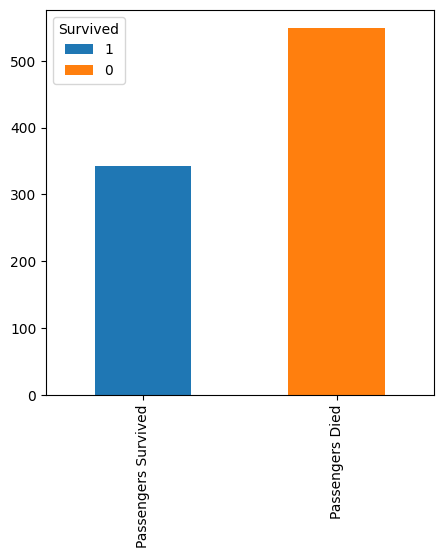

In [13]:
bar_chart_stacked(train_data, "Survived")

### Observations:

As expected the majority of passengers in the training data died. Only 38% survived the disaster. So the training data suffers from data imbalance but it is not severe which is why I will not cosider techniques like sampling to tackle the imbalance.

## 2.3 Analyse Feature Sex

In [14]:
train_data["Sex"].value_counts().to_frame()

,count
Sex,
male,577
female,314


### Observation:
As the majority of passenger were we could infer that the majority of survivors were men.

We can check this assumption by looking at the bar chart below:

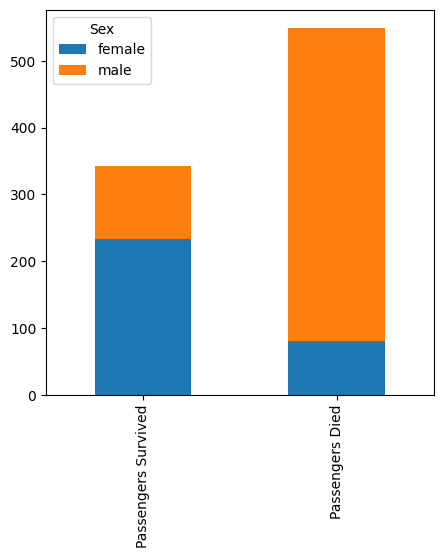

In [15]:
bar_chart_stacked(train_data,"Sex")

In [16]:
women = train_data.loc[train_data.Sex == "female"]["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived: ", rate_women)

% of women who survived:  0.7420382165605095


In [17]:
men =train_data.loc[train_data.Sex == "male"]["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived: ", rate_men)

% of men who survived:  0.18890814558058924


In [18]:
train_data.groupby("Sex").Survived.mean().to_frame()
                   

,Survived
Sex,
female,0.742038
male,0.188908


### Observations:
Here, we can see the even though the majority of the passenger were male, the majority of survivors were female. The key observation here is that the survival rate for female passengers is 4 times higher than the survival rate of male passengers.

## 2.4 Analyse Feature Pclass:

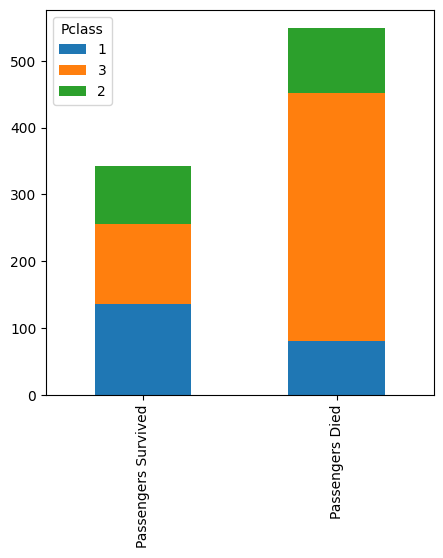

In [19]:
bar_chart_stacked(train_data, "Pclass")

In [20]:
pd.pivot_table(train_data, index = "Survived", columns = "Pclass", values ="Ticket", aggfunc ="count")

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [21]:
train_data.groupby(["Pclass"]).Survived.mean().to_frame()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


### Observations: 

From the plots and tables above it becomes clear that the Pclass is an important factor to consider.

   -  Most passenger had class 3 tickets, yet only 24% of class 3 passengers survived.
   - Almost 63% of the passenger from class 1 survived.
   - Also approx 50% of the class 2 passenger survived.

One questions that comes into mind is:

Is the class or sex the deciding factor?

In [22]:
def bar_chart_compare(dataset, feature1, feature2=None, title = "Survival rate by sex and class'"):
    plt.figure(figsize = [5,5])
    plt.title(title)
    g = sns.barplot(x=feature1, y='Survived', hue=feature2, errorbar=None, data=dataset).set_ylabel('Survival rate')


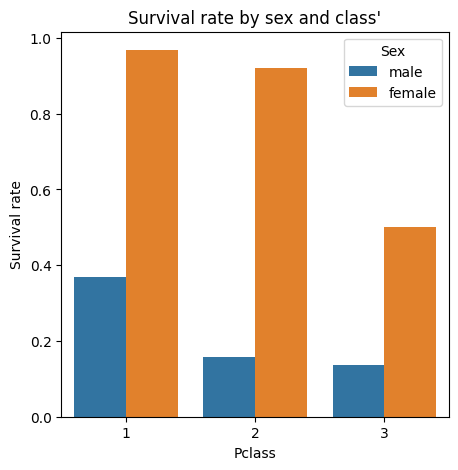

In [23]:
bar_chart_compare(train_data,"Pclass", "Sex")

In [24]:
pd.pivot_table(train_data, index ="Survived", columns = ["Pclass", "Sex"], values= "Ticket", aggfunc = "count" )

Pclass        1           2           3     
Sex      female male female male female male
Survived                                    
0             3   77      6   91     72  300
1            91   45     70   17     72   47

In [25]:
train_data.groupby(["Pclass","Sex"]).Survived.mean().to_frame()

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

### Observations;

Here, we can clearly see that the question was justified. Irrespective of the class the most important factor when it comes to surviving was gender. (At least between Sex and Pclass) However, men in class 1 had a significantly higher chance of survival when they bought class 1 tickets. This just shows to say that we should keep both features as both yield insightful information that should help our model.

   - Survival Rate females 1. Class: 96,8%

   - Survival Rate females 2. Class: 92,1%

   - Survival Rate females 3. Class: 50%

   - Survival Rate male 1. Class: 36.8%
     (still significantly lower than 3. class females)


In [26]:
from sklearn.ensemble import RandomForestClassifier
y = train_data["Survived"]
features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators =100, max_depth =5, random_state=1)
model.fit(X,y)
predictions = model.predict(X_test)
output = pd.DataFrame({"PassengerId": test_data.PassengerId, "Survived": predictions})
print ("You submission was successfully saved")

You submission was successfully saved
